In [1]:
import xarray as xr
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Read precomputed CORE-II-NYF simulations in OM4

In [10]:
param = xr.open_dataset('/scratch/pp2681/calibration/OM4-NIF-5-years/param.nc').drop_vars('time')

In [11]:
def ave3d(array, param):
    return (array * param.dxt * param.dyt * param.dz * param.mask_nan).sum(['xh','yh','z_l']) / (param.dxt * param.dyt * param.dz * param.mask_nan).sum(['xh','yh','z_l'])

In [12]:
def read_data(exp='unparameterized'):
    return xr.open_dataset(os.path.join('/scratch/pp2681/calibration/OM4-NIF-5-years', f'{exp}.nc')).thetao

In [12]:
ann = ave3d(read_data('ANN-greenline'), param)
gm = ave3d(read_data('GM'), param)
control = ave3d(read_data(), param)

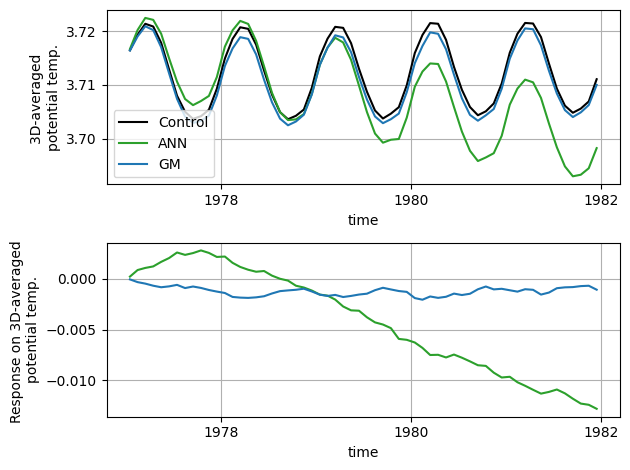

In [13]:
plt.subplot(2,1,1)
control.plot(color='k', label='Control')
ann.plot(color='tab:green', label='ANN')
gm.plot(color='tab:blue', label='GM')
plt.legend()
plt.ylabel('3D-averaged \npotential temp.')
plt.grid()
plt.subplot(2,1,2)
(ann-control).plot(color='tab:green', label='ANN')
(gm-control).plot(color='tab:blue', label='GM')
plt.grid()
plt.ylabel('Response on 3D-averaged \npotential temp.')

plt.tight_layout()

# Create a dataset of all possible responses
We consider all possible pairs of 19 experiments to compute responses. We seek to construct the data matrix of size:
$$
\mathbf{X} \in \mathbb{R}^{n \times k},
$$
where $k$ is the number of not-NaN values in 3D array of potential temperature. The number $n$ represents all possible responses to be used for computation of PCA. $n$ equals to the number of time snapshots (60) times the number of response combinations (19*18/2=171).

## Transform 3D field into a vector

In [13]:
# transform 3D field of temperature into a 1D vector
def to_vector(data):
    # Flatten the data and mask
    data_flat = data.stack(flat=("z_l","yh","xh"))

    # Extract valid values (non-NaN in mask)
    valid_values = data_flat.where(data_flat.notnull(), drop=True)

    return valid_values

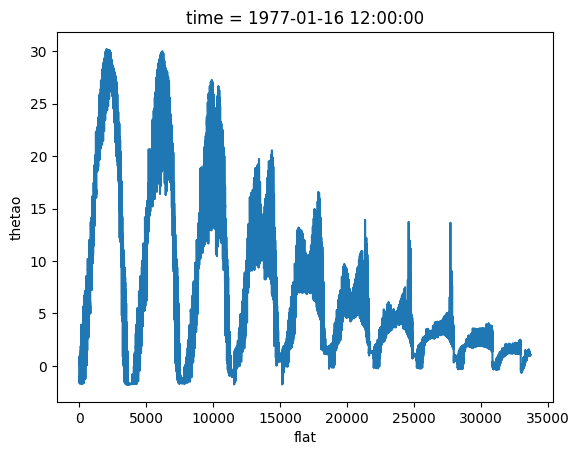

In [66]:
vector = to_vector(read_data())
vector[0].drop_vars('flat').plot()

## Backward transformation is simply .unstack()

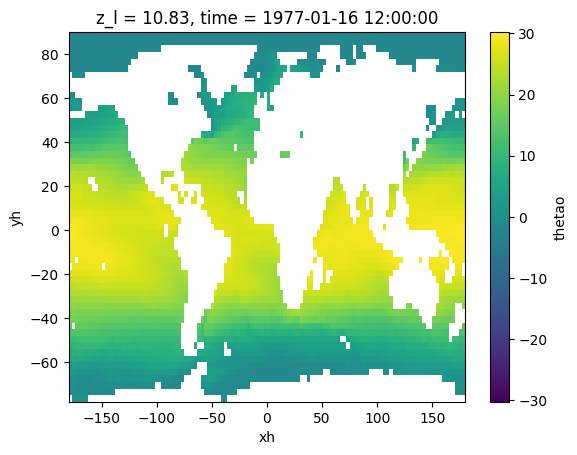

In [69]:
vector.unstack()[0][0].plot(cmap='viridis')

## Create a data matrix by iterating over experiments

In [235]:
exps = ['unparameterized', 'unparameterized-0.03', 'unparameterized-0.09',
            'JHAH15', 'GM', 'vert-diff',
            'ZB20-Klower', 'ZB20-Reynolds', 'ZB20-Smooth-1.0', 'ZB20-Smooth-2.5',
            'ANN-greenline', 'ANN-redline', 'ANN-FGR-2', 'ANN-Taper', 'ANN-strain',
            'ANN-1x1', 'ANN-3x3-32-32', 'ANN-3x3-EXP2', 'ANN-5x5-Klower']

In [236]:
# Consider all pairs. We consider all ordered combinations to gaurantee zero sample mean columnwise in the data matrix 
# We resample data in 12-month averages to introduce more averaging and have more powerfull PCA-decomposition
# We normalize each pair of experiments individually because we want our model be agnostic to the magnitude of response
data_matrix = []
response_std = []
for i in range(len(exps)):
    for j in range(len(exps)):
        if i!=j:
            exp1 = read_data(exps[i])
            exp2 = read_data(exps[j])
            vector = to_vector(exp1-exp2).coarsen({'time':12}).mean().values
            data_matrix.append(vector)
            response_std.append(vector.std() * np.ones([5,1]))
# Stack all experiment pairs and times into one dimension (first)
data_matrix = np.vstack(data_matrix)
response_std = np.vstack(response_std)

In [237]:
# Here 33715 is the number of non-NaN 3D grid points
# 6840 = 60/12*19*18
np.shape(data_matrix)

(1710, 33715)

In [239]:
# np.save('data/data_matrix.npy', data_matrix.astype('float32'))
# np.save('data/response_std.npy', response_std.astype('float32'))

In [240]:
data_matrix = np.load('data/data_matrix.npy')
response_std = np.load('data/response_std.npy')

Text(0, 0.5, 'columwise mean')

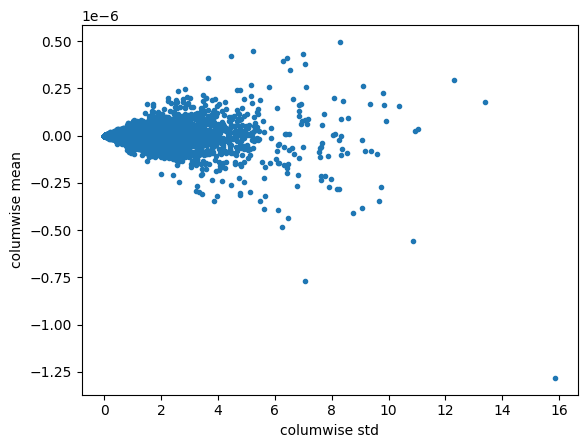

In [241]:
# Sample mean columnwise is strictly zero by construction
# Columwise std is on the order of 1 so we can skip this normalization step to avoid confusion
plt.plot((data_matrix/response_std).std(0), data_matrix.mean(0),'.')
plt.xlabel('columwise std')
plt.ylabel('columwise mean')
#plt.gca().set_aspect(1)

#plt.xlim([0, 20])
#plt.ylim([-0.3, 0.3])

In [242]:
import scipy
# Compute 30 SVD components
# Divide by standard deviation prior to computing svd. We will renormalize the result.
data_matrix_normalized_pairwise = data_matrix / response_std
data_matrix_normalized = data_matrix_normalized_pairwise / data_matrix_normalized_pairwise.std(0)
pairwise_columnwise_norm = data_matrix_normalized_pairwise.std(0) * response_std
%time U, s, Vt = scipy.sparse.linalg.svds(data_matrix_normalized, k=10)

CPU times: user 1.64 s, sys: 733 μs, total: 1.64 s
Wall time: 276 ms


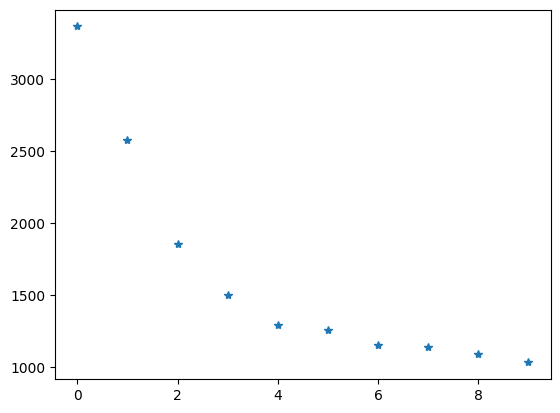

In [243]:
plt.plot(np.sort(s)[::-1], ls='', marker='*')

In [244]:
print(np.shape(U))
print(np.shape(s))
print(np.shape(Vt))
print(np.shape(data_matrix))

(1710, 10)
(10,)
(10, 33715)
(1710, 33715)


In [245]:
data_matrix_svd10 =((U*s)@Vt) * pairwise_columnwise_norm

In [246]:
np.sqrt(((data_matrix_svd10 - data_matrix)**2).mean())

0.10948555

In [247]:
np.sqrt(((data_matrix)**2).mean())

0.21485697

## Check how accurate 30-svd temperature reconstruction for predicting time series of volume-averaged temperature

In [327]:
pair=6
idx = pair*5 + np.arange(5)

In [328]:
vector = to_vector(read_data()).coarsen({'time':12}).mean()*0

In [329]:
response_true = (vector + data_matrix[idx]).unstack()

In [330]:
response_svd10 = (vector + data_matrix_svd10[idx]).unstack()

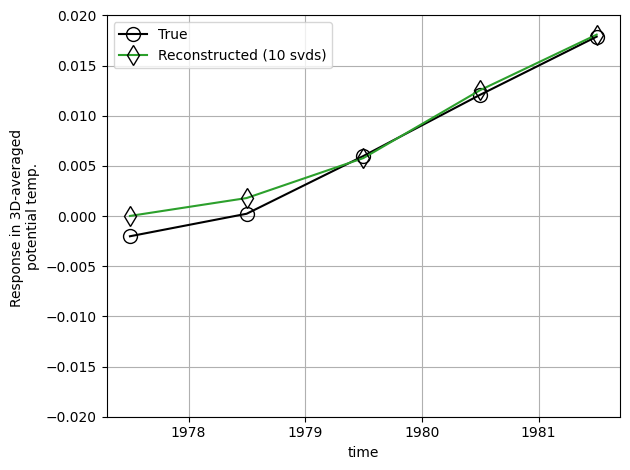

In [443]:
ave3d(response_true, param).plot(color='k', label='True', marker='o', markerfacecolor='none', markersize=10)
#ave3d(response_svd30, param).plot(color='tab:blue', label='Reconstructed (30 svds)')
ave3d(response_svd10, param).plot(color='tab:green', label='Reconstructed (10 svds)', marker='d', markersize=10, markeredgecolor='k', markerfacecolor='none')
plt.grid()
plt.ylabel('Response in 3D-averaged \npotential temp.')
plt.legend()
plt.ylim([-0.02, 0.02])

plt.tight_layout()

# Autoregressive linear model for first 10 svd PCs
For simplicity we wish to initialize model with 3rd and 4th years and make a prediction for 4th and 5th years

In [254]:
print(np.shape(U))
print(np.shape(s))
print(np.shape(Vt))
print(np.shape(data_matrix))

(1710, 10)
(10,)
(10, 33715)
(1710, 33715)


In [268]:
# Response in 3rd year
r3 = U[2:None:5]
# Response in 4th year
r4 = U[3:None:5]
# Response in 5th yeat
r5 = U[4:None:5]

In [274]:
np.shape(r3)

(342, 10)

# Fitting linear response model
$$
r_5 - M r_4 = r_4 - M r_3
$$
or simply
$$
(r_5-r_4) = M (r_4 - r_3)
$$
Let us define $y=r_5-r_4 \in \mathbb{R}^{10 \times 342}$, $x=r_4-r_3 \in \mathbb{R}^{10 \times 342}$, $M \in \mathbb{R}^{10\times10}$ and the equation reads as:
$$
y = M x.
$$

For this model we have 100 free parameters to fit and 342 points. So, the least squares procedure can be applied

In [277]:
x = (r4-r3).T
y = (r5-r4).T

In [280]:
# Least squares solution
M = y @ x.T @ np.linalg.inv(x @ x.T)

In [285]:
# The relative error of linear response model is pretty accurate
np.sqrt(((y - M@x)**2).mean()) /  np.sqrt(((y)**2).mean())

0.24571271

# Show the 5th year prediction

In [363]:
U_prediction = U
U_prediction[4:None:5] = (M@x + r4.T).T
data_matrix_prediction =((U_prediction*s)@Vt) * pairwise_columnwise_norm

In [436]:
pair=8
idx = pair*5 + np.arange(5)

In [437]:
response_prediction = (vector + data_matrix_prediction[idx]).unstack()

In [438]:
response_true = (vector + data_matrix[idx]).unstack()

In [439]:
response_svd10 = (vector + data_matrix_svd10[idx]).unstack()

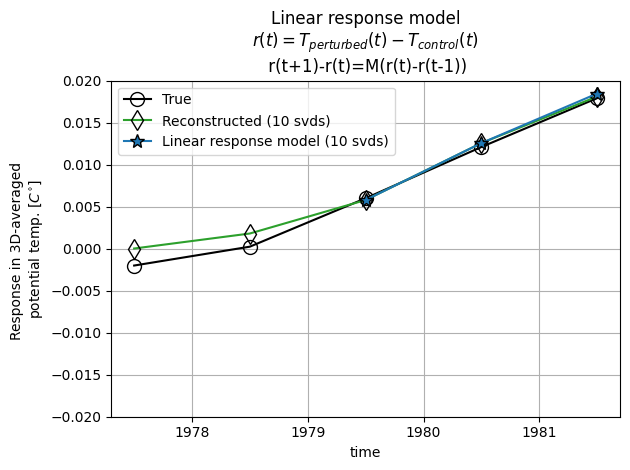

In [442]:
ave3d(response_true, param).plot(color='k', label='True', marker='o', markerfacecolor='none', markersize=10)
ave3d(response_svd10, param).plot(color='tab:green', label='Reconstructed (10 svds)', marker='d', markersize=10, markeredgecolor='k', markerfacecolor='none')
ave3d(response_prediction, param)[-3:None].plot(color='tab:blue', label='Linear response model (10 svds)', marker='*', markersize=10, markeredgecolor='k')
                                                
                                                
plt.grid()
plt.ylabel('Response in 3D-averaged \npotential temp. [$C^{\circ}$]')
plt.legend()
plt.ylim([-0.02, 0.02])

plt.title('Linear response model\n$r(t)=T_{perturbed}(t)-T_{control}(t)$\n r(t+1)-r(t)=M(r(t)-r(t-1))')
plt.tight_layout()
plt.savefig('linear-response-model.pdf', dpi=200)

In [445]:
np.save('data/M.npy', M)

In [446]:
np.save('data/s.npy', s)
np.save('data/Vt.npy', Vt)
np.save('data/pairwise_columnwise_norm.npy', pairwise_columnwise_norm)

In [451]:
# So the procedure can be applied for infinitely long rollouts as the spectrum is within the unit circle.
np.max(np.abs(np.linalg.eig(M).eigenvalues))

0.8761939